In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
data = preproc(data)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 4min 5s
Wall time: 4min 18s


In [32]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 15.6 ms
Wall time: 20 ms


# CV

### Definition

In [33]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler
EPOCHS = 'unrestricted' # use 'unrestricted' for full convergence

In [34]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, epochs='unrestricted', lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch=epochs,
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

In [35]:
probability_mass_distribution_names = ['uniform', 'random', 'gaussian', 'geometric']

### Evaluation

In [36]:
model_names = ['A', 'B',
               'vanilla_pre', 'vanilla_post',
               'OT_pre_uniform', 'OT_post_uniform',
               'OT_pre_random', 'OT_post_random',
               'OT_pre_gaussian', 'OT_post_gaussian',
               'OT_pre_geometric', 'OT_post_geometric',
               'random']
scores = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names},}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 20027.37it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 105 - Train Loss: 0.1580 / Validation Loss: 0.4889 / Train acc: 0.9433 / Val acc: 0.8169 / Learning Rate : 0.0000:   0%|          | 105/1000000 [04:23<708:06:46,  2.55s/it]

Training has converged after 105 epochs (lr < 1e-06)


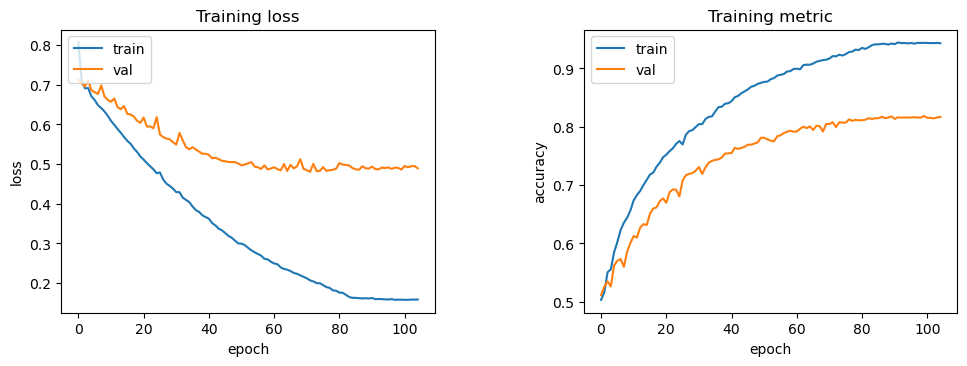

Epoch: 105 - Train Loss: 0.1580 / Validation Loss: 0.4889 / Train acc: 0.9433 / Val acc: 0.8169 / Learning Rate : 0.0000:   0%|          | 105/1000000 [04:24<698:22:59,  2.51s/it]


Starting training for model B


Epoch: 46 - Train Loss: 0.1556 / Validation Loss: 0.4026 / Train acc: 0.9458 / Val acc: 0.8412 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:56<701:12:33,  2.52s/it]

Training has converged after 46 epochs (lr < 1e-06)


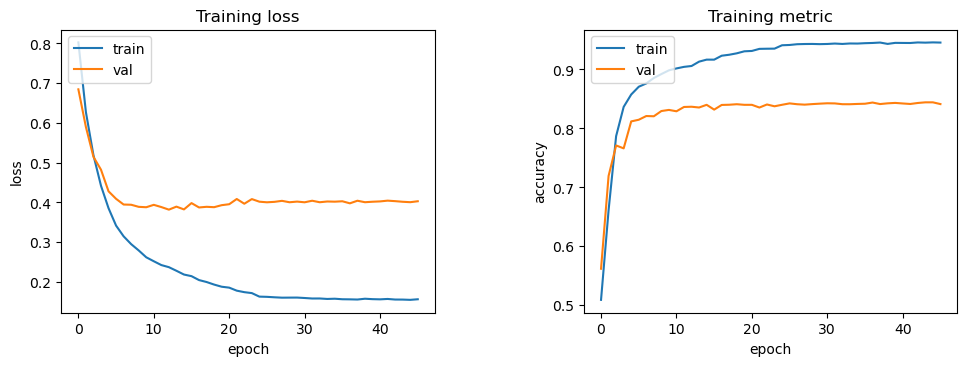

Epoch: 46 - Train Loss: 0.1556 / Validation Loss: 0.4026 / Train acc: 0.9458 / Val acc: 0.8412 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:56<706:24:50,  2.54s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
A loss: 0.43881310025850934 - accuracy: 0.8405985809178743 - f1: 0.8388625383377075
B loss: 0.40240475287040073 - accuracy: 0.8415090957125604 - f1: 0.8414015173912048
random loss: 0.7208763211965561 - accuracy: 0.5027669270833333 - f1: 0.5028774738311768
OT_pre_uniform loss: 0.4882264931996663 - accuracy: 0.793780193236715 - f1: 0.7945159077644348
OT_pre_random loss: 0.4910265728831291 - accuracy: 0.7928059895833333 - f1: 0.7945159077644348
OT_pre_gaussian loss: 0.48575125137964886 - accuracy: 0.7947543968900966 - f1: 0.7945159077644348
OT_pre_geometric loss: 0.4839046746492386 - accuracy: 0.7958677724939613 - f1: 0.7945159077644348
vanilla_pre loss: 1.953924039999644 - accuracy: 0.5345264379528984 - f1: 0.5350372195243835
Starting retraining for model vanilla fusion


Epoch: 77 - Train Loss: 0.1657 / Validation Loss: 0.4239 / Train acc: 0.9451 / Val acc: 0.8221 / Learning Rate : 0.0000:   0%|          | 77/1000000 [03:01<657:33:17,  2.37s/it]

Training has converged after 77 epochs (lr < 1e-06)


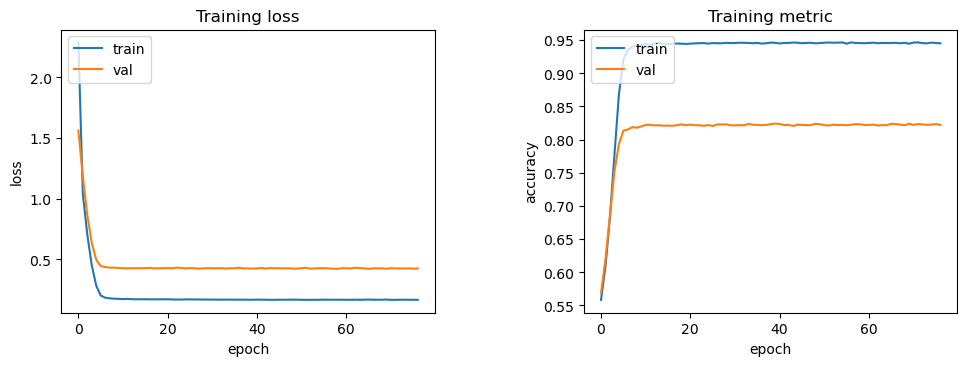

Epoch: 77 - Train Loss: 0.1657 / Validation Loss: 0.4239 / Train acc: 0.9451 / Val acc: 0.8221 / Learning Rate : 0.0000:   0%|          | 77/1000000 [03:01<654:22:10,  2.36s/it]


Starting retraining for model OT fusion - uniform


Epoch: 55 - Train Loss: 0.1734 / Validation Loss: 0.4260 / Train acc: 0.9448 / Val acc: 0.8234 / Learning Rate : 0.0000:   0%|          | 55/1000000 [02:11<671:17:57,  2.42s/it]

Training has converged after 55 epochs (lr < 1e-06)


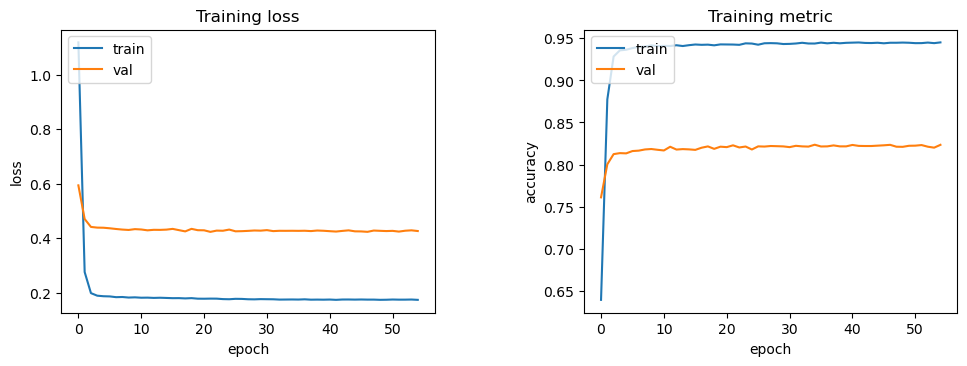

Epoch: 55 - Train Loss: 0.1734 / Validation Loss: 0.4260 / Train acc: 0.9448 / Val acc: 0.8234 / Learning Rate : 0.0000:   0%|          | 55/1000000 [02:12<667:14:06,  2.40s/it]


Starting retraining for model OT fusion - random


Epoch: 99 - Train Loss: 0.1687 / Validation Loss: 0.4214 / Train acc: 0.9472 / Val acc: 0.8270 / Learning Rate : 0.0000:   0%|          | 99/1000000 [03:53<606:09:01,  2.18s/it]

Training has converged after 99 epochs (lr < 1e-06)


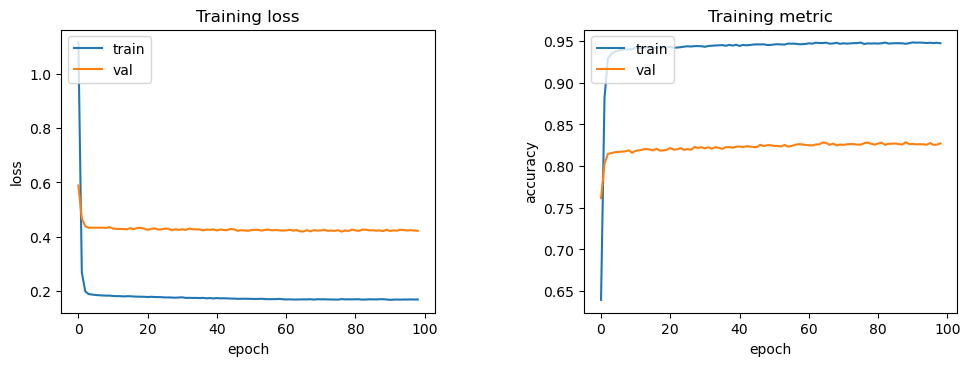

Epoch: 99 - Train Loss: 0.1687 / Validation Loss: 0.4214 / Train acc: 0.9472 / Val acc: 0.8270 / Learning Rate : 0.0000:   0%|          | 99/1000000 [03:53<655:55:28,  2.36s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 71 - Train Loss: 0.1729 / Validation Loss: 0.4254 / Train acc: 0.9450 / Val acc: 0.8239 / Learning Rate : 0.0000:   0%|          | 71/1000000 [02:30<573:48:33,  2.07s/it]

Training has converged after 71 epochs (lr < 1e-06)


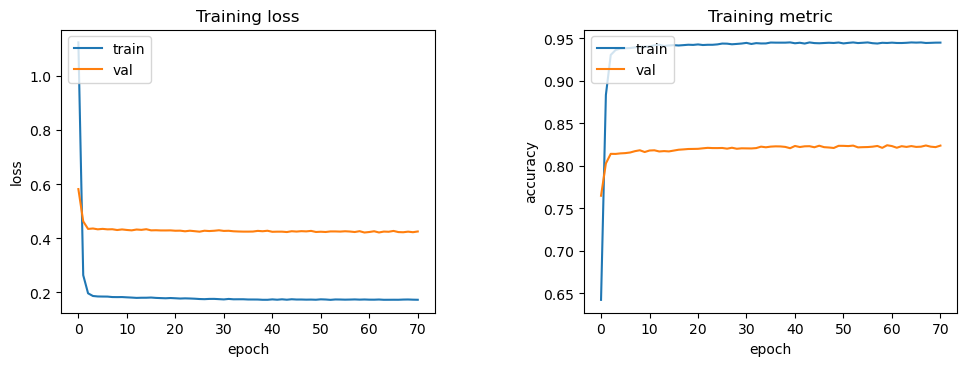

Epoch: 71 - Train Loss: 0.1729 / Validation Loss: 0.4254 / Train acc: 0.9450 / Val acc: 0.8239 / Learning Rate : 0.0000:   0%|          | 71/1000000 [02:30<589:23:07,  2.12s/it]


Starting retraining for model OT fusion - geometric


Epoch: 101 - Train Loss: 0.1658 / Validation Loss: 0.4227 / Train acc: 0.9476 / Val acc: 0.8268 / Learning Rate : 0.0000:   0%|          | 101/1000000 [03:30<570:31:42,  2.05s/it]

Training has converged after 101 epochs (lr < 1e-06)


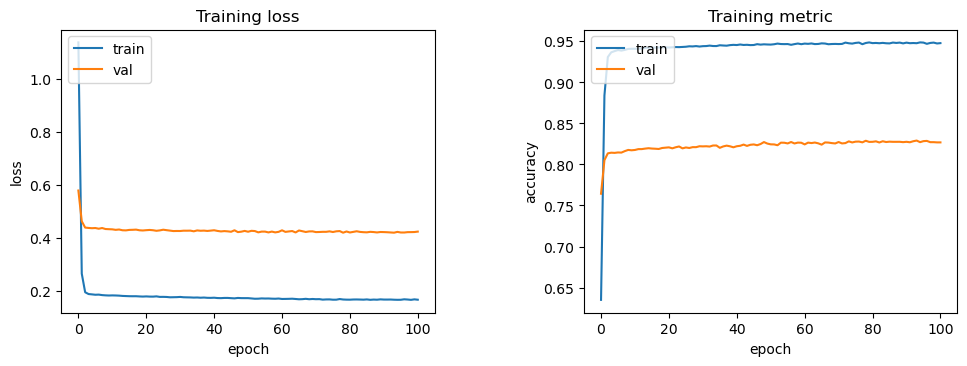

Epoch: 101 - Train Loss: 0.1658 / Validation Loss: 0.4227 / Train acc: 0.9476 / Val acc: 0.8268 / Learning Rate : 0.0000:   0%|          | 101/1000000 [03:30<578:18:47,  2.08s/it]


OT_post_uniform loss: 0.42891671260197956 - accuracy: 0.8218646210748792 - f1: 0.8222748637199402
OT_post_random loss: 0.4220324804385503 - accuracy: 0.8254665798611112 - f1: 0.8251523375511169
OT_post_gaussian loss: 0.4240735744436582 - accuracy: 0.8231407570954106 - f1: 0.8224441409111023
OT_post_geometric loss: 0.4210142567753792 - accuracy: 0.8278843976449275 - f1: 0.8275219798088074
vanilla_post loss: 0.4282021149992943 - accuracy: 0.8197039175724636 - f1: 0.8207515478134155
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 19997.05it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 92 - Train Loss: 0.1914 / Validation Loss: 0.5151 / Train acc: 0.9291 / Val acc: 0.7987 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:18<597:39:11,  2.15s/it]

Training has converged after 92 epochs (lr < 1e-06)


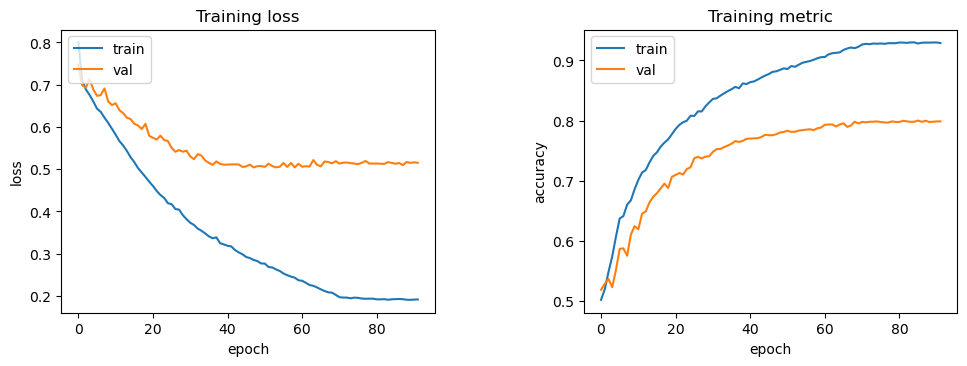

Epoch: 92 - Train Loss: 0.1914 / Validation Loss: 0.5151 / Train acc: 0.9291 / Val acc: 0.7987 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:19<600:55:23,  2.16s/it]


Starting training for model B


Epoch: 50 - Train Loss: 0.1625 / Validation Loss: 0.4297 / Train acc: 0.9417 / Val acc: 0.8331 / Learning Rate : 0.0000:   0%|          | 50/1000000 [01:48<598:40:28,  2.16s/it]

Training has converged after 50 epochs (lr < 1e-06)


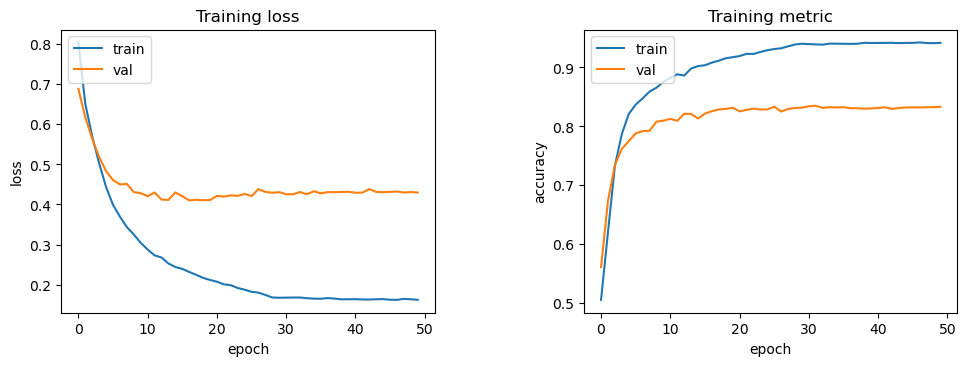

Epoch: 50 - Train Loss: 0.1625 / Validation Loss: 0.4297 / Train acc: 0.9417 / Val acc: 0.8331 / Learning Rate : 0.0000:   0%|          | 50/1000000 [01:48<601:42:44,  2.17s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
A loss: 0.4693136711915334 - accuracy: 0.823588273728941 - f1: 0.8233203291893005
B loss: 0.43413442373275757 - accuracy: 0.8311739667945247 - f1: 0.8317820429801941
random loss: 0.7648503084977468 - accuracy: 0.4930136413206979 - f1: 0.4928075671195984
OT_pre_uniform loss: 3.2620594104131064 - accuracy: 0.5123968204723225 - f1: 0.5121001601219177
OT_pre_random loss: 3.2644474705060325 - accuracy: 0.5126729843561973 - f1: 0.5121001601219177
OT_pre_gaussian loss: 3.2794087330500283 - accuracy: 0.5110160010529482 - f1: 0.5121001601219177
OT_pre_geometric loss: 3.251305858294169 - accuracy: 0.5147442134852587 - f1: 0.5121001601219177
vanilla_pre loss: 0.9865512996912003 - accuracy: 0.6475367356723827 - f1: 0.6481637954711914
Starting retraining for model vanilla fusion


Epoch: 83 - Train Loss: 0.1962 / Validation Loss: 0.4695 / Train acc: 0.9324 / Val acc: 0.7942 / Learning Rate : 0.0000:   0%|          | 83/1000000 [02:51<570:48:31,  2.06s/it]

Training has converged after 83 epochs (lr < 1e-06)


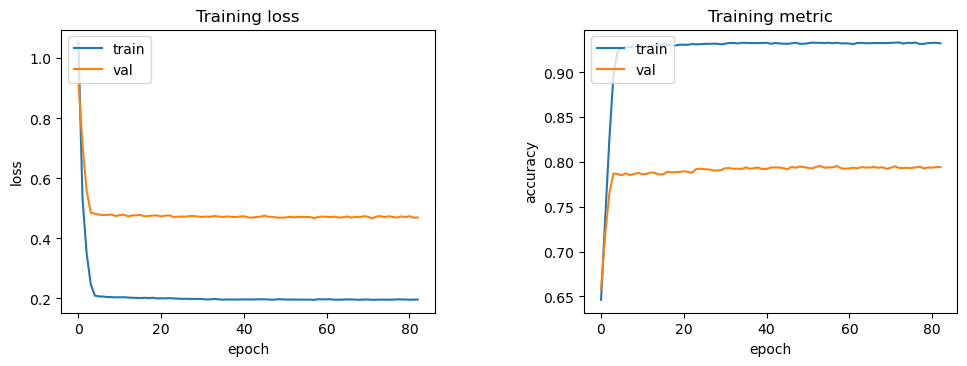

Epoch: 83 - Train Loss: 0.1962 / Validation Loss: 0.4695 / Train acc: 0.9324 / Val acc: 0.7942 / Learning Rate : 0.0000:   0%|          | 83/1000000 [02:51<574:09:55,  2.07s/it]


Starting retraining for model OT fusion - uniform


Epoch: 81 - Train Loss: 0.1877 / Validation Loss: 0.4524 / Train acc: 0.9367 / Val acc: 0.8057 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<577:02:26,  2.08s/it]

Training has converged after 81 epochs (lr < 1e-06)


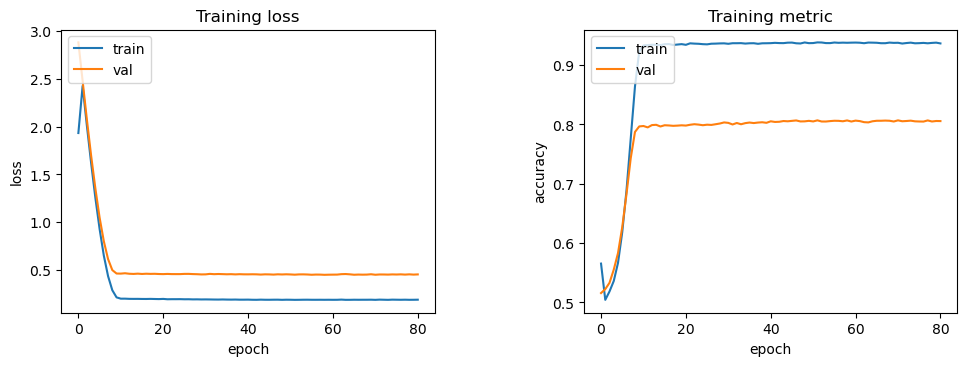

Epoch: 81 - Train Loss: 0.1877 / Validation Loss: 0.4524 / Train acc: 0.9367 / Val acc: 0.8057 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<574:36:43,  2.07s/it]


Starting retraining for model OT fusion - random


Epoch: 81 - Train Loss: 0.1862 / Validation Loss: 0.4507 / Train acc: 0.9376 / Val acc: 0.8056 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<569:33:10,  2.05s/it]

Training has converged after 81 epochs (lr < 1e-06)


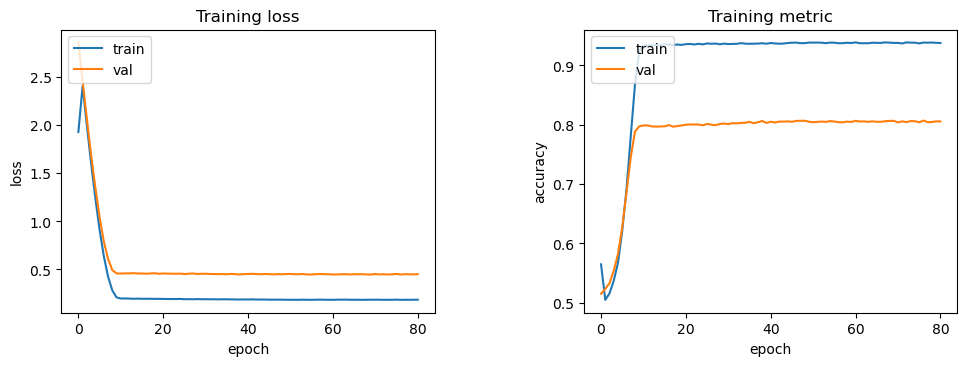

Epoch: 81 - Train Loss: 0.1862 / Validation Loss: 0.4507 / Train acc: 0.9376 / Val acc: 0.8056 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<574:00:31,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 87 - Train Loss: 0.1849 / Validation Loss: 0.4457 / Train acc: 0.9395 / Val acc: 0.8083 / Learning Rate : 0.0000:   0%|          | 87/1000000 [02:59<580:35:54,  2.09s/it]

Training has converged after 87 epochs (lr < 1e-06)


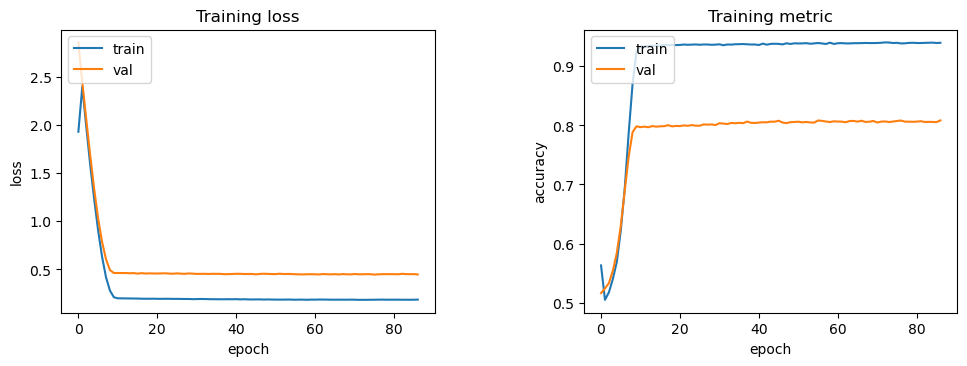

Epoch: 87 - Train Loss: 0.1849 / Validation Loss: 0.4457 / Train acc: 0.9395 / Val acc: 0.8083 / Learning Rate : 0.0000:   0%|          | 87/1000000 [03:00<574:45:34,  2.07s/it]


Starting retraining for model OT fusion - geometric


Epoch: 87 - Train Loss: 0.1846 / Validation Loss: 0.4489 / Train acc: 0.9386 / Val acc: 0.8064 / Learning Rate : 0.0000:   0%|          | 87/1000000 [02:59<575:31:47,  2.07s/it]

Training has converged after 87 epochs (lr < 1e-06)


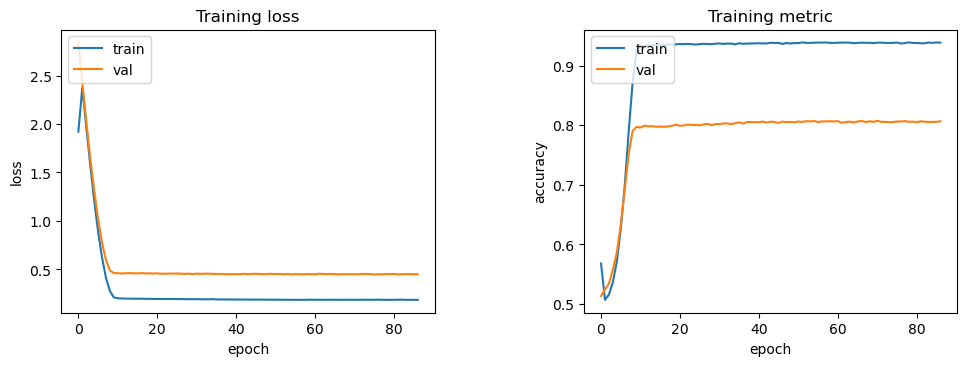

Epoch: 87 - Train Loss: 0.1846 / Validation Loss: 0.4489 / Train acc: 0.9386 / Val acc: 0.8064 / Learning Rate : 0.0000:   0%|          | 87/1000000 [02:59<574:08:41,  2.07s/it]


OT_post_uniform loss: 0.45016510784626007 - accuracy: 0.8063850265117327 - f1: 0.8057200908660889
OT_post_random loss: 0.4489661082625389 - accuracy: 0.8071101036025873 - f1: 0.8069047331809998
OT_post_gaussian loss: 0.45097871373097104 - accuracy: 0.8053150383574007 - f1: 0.8069047331809998
OT_post_geometric loss: 0.4484563966592153 - accuracy: 0.8061088626278581 - f1: 0.8057200908660889
vanilla_post loss: 0.47584179043769836 - accuracy: 0.7925950473826715 - f1: 0.7935352921485901
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22215.10it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 94 - Train Loss: 0.1675 / Validation Loss: 0.5058 / Train acc: 0.9397 / Val acc: 0.8067 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:23<599:07:57,  2.16s/it]

Training has converged after 94 epochs (lr < 1e-06)


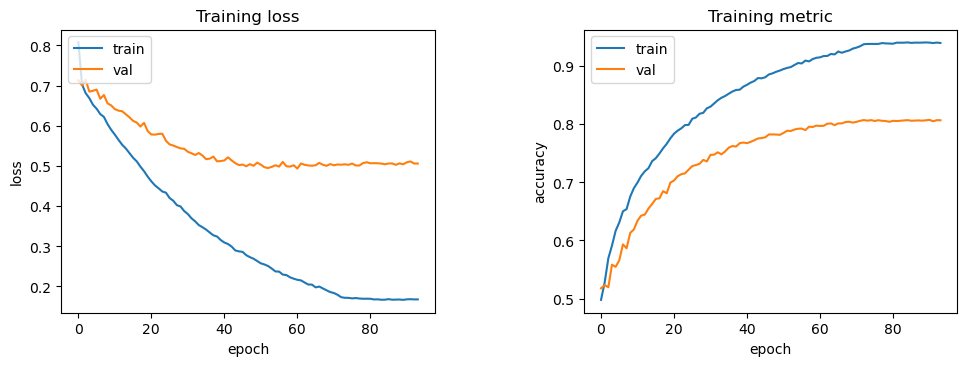

Epoch: 94 - Train Loss: 0.1675 / Validation Loss: 0.5058 / Train acc: 0.9397 / Val acc: 0.8067 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:23<601:19:14,  2.16s/it]


Starting training for model B


Epoch: 44 - Train Loss: 0.1573 / Validation Loss: 0.4010 / Train acc: 0.9447 / Val acc: 0.8416 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<597:53:08,  2.15s/it]

Training has converged after 44 epochs (lr < 1e-06)


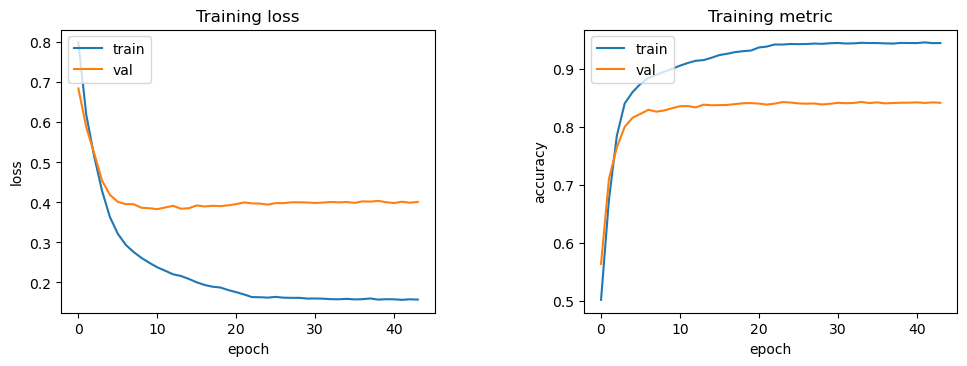

Epoch: 44 - Train Loss: 0.1573 / Validation Loss: 0.4010 / Train acc: 0.9447 / Val acc: 0.8416 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<601:44:36,  2.17s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
A loss: 0.4720676789681117 - accuracy: 0.8280815188778581 - f1: 0.8285665512084961
B loss: 0.3982010881106059 - accuracy: 0.843010820923586 - f1: 0.8419361114501953
random loss: 0.7449606408675512 - accuracy: 0.48923078369434414 - f1: 0.48959213495254517
OT_pre_uniform loss: 0.5057329485813776 - accuracy: 0.7750662793321299 - f1: 0.775596559047699
OT_pre_random loss: 0.5071674684683481 - accuracy: 0.7745139515643802 - f1: 0.775596559047699
OT_pre_gaussian loss: 0.503777340054512 - accuracy: 0.775756689041817 - f1: 0.775596559047699
OT_pre_geometric loss: 0.5056425333023071 - accuracy: 0.776723262635379 - f1: 0.775596559047699
vanilla_pre loss: 0.7984472960233688 - accuracy: 0.6926260717509025 - f1: 0.6931799054145813
Starting retraining for model vanilla fusion


Epoch: 64 - Train Loss: 0.1780 / Validation Loss: 0.4398 / Train acc: 0.9450 / Val acc: 0.8101 / Learning Rate : 0.0000:   0%|          | 64/1000000 [02:12<581:41:14,  2.09s/it]

Training has converged after 64 epochs (lr < 1e-06)


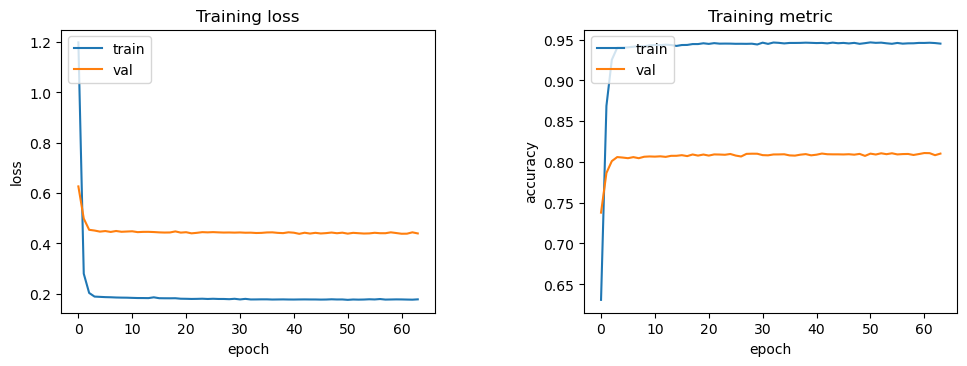

Epoch: 64 - Train Loss: 0.1780 / Validation Loss: 0.4398 / Train acc: 0.9450 / Val acc: 0.8101 / Learning Rate : 0.0000:   0%|          | 64/1000000 [02:12<574:24:10,  2.07s/it]


Starting retraining for model OT fusion - uniform


Epoch: 81 - Train Loss: 0.1713 / Validation Loss: 0.4258 / Train acc: 0.9470 / Val acc: 0.8213 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<570:45:34,  2.05s/it]

Training has converged after 81 epochs (lr < 1e-06)


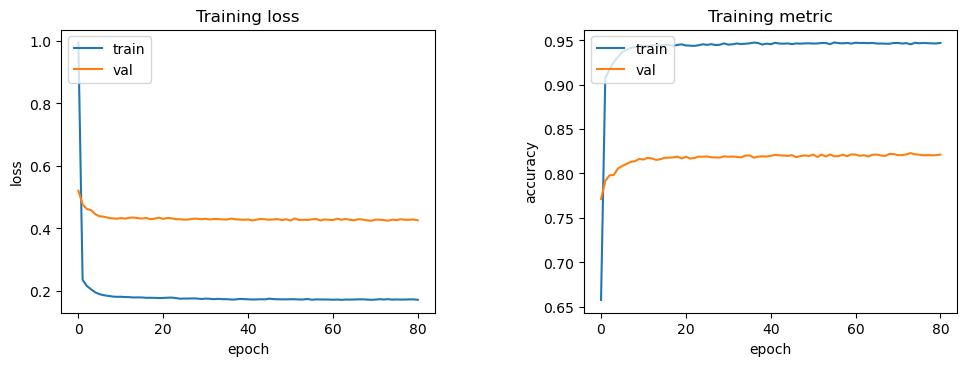

Epoch: 81 - Train Loss: 0.1713 / Validation Loss: 0.4258 / Train acc: 0.9470 / Val acc: 0.8213 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<573:51:28,  2.07s/it]


Starting retraining for model OT fusion - random


Epoch: 81 - Train Loss: 0.1677 / Validation Loss: 0.4272 / Train acc: 0.9477 / Val acc: 0.8213 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<575:25:05,  2.07s/it]

Training has converged after 81 epochs (lr < 1e-06)


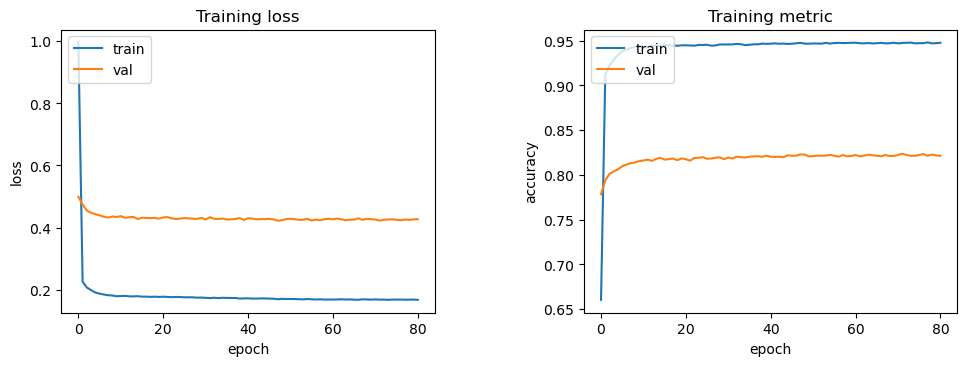

Epoch: 81 - Train Loss: 0.1677 / Validation Loss: 0.4272 / Train acc: 0.9477 / Val acc: 0.8213 / Learning Rate : 0.0000:   0%|          | 81/1000000 [02:47<574:26:14,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 60 - Train Loss: 0.1760 / Validation Loss: 0.4312 / Train acc: 0.9449 / Val acc: 0.8187 / Learning Rate : 0.0000:   0%|          | 60/1000000 [02:03<571:41:15,  2.06s/it]

Training has converged after 60 epochs (lr < 1e-06)


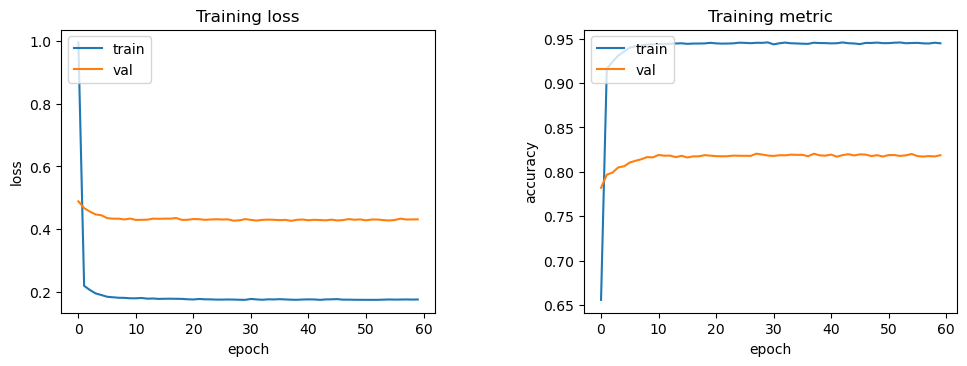

Epoch: 60 - Train Loss: 0.1760 / Validation Loss: 0.4312 / Train acc: 0.9449 / Val acc: 0.8187 / Learning Rate : 0.0000:   0%|          | 60/1000000 [02:04<574:21:24,  2.07s/it]


Starting retraining for model OT fusion - geometric


Epoch: 67 - Train Loss: 0.1711 / Validation Loss: 0.4254 / Train acc: 0.9468 / Val acc: 0.8208 / Learning Rate : 0.0000:   0%|          | 67/1000000 [02:18<574:50:57,  2.07s/it]

Training has converged after 67 epochs (lr < 1e-06)


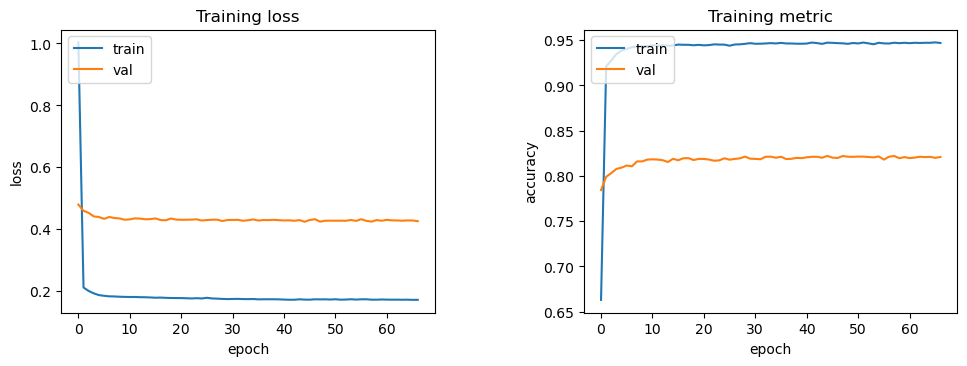

Epoch: 67 - Train Loss: 0.1711 / Validation Loss: 0.4254 / Train acc: 0.9468 / Val acc: 0.8208 / Learning Rate : 0.0000:   0%|          | 67/1000000 [02:18<574:47:34,  2.07s/it]


OT_post_uniform loss: 0.43549489229917526 - accuracy: 0.8159485230520458 - f1: 0.8163818717002869
OT_post_random loss: 0.42690631995598477 - accuracy: 0.8230259570547532 - f1: 0.822304904460907
OT_post_gaussian loss: 0.4334692781170209 - accuracy: 0.8170978348751504 - f1: 0.8185818195343018
OT_post_geometric loss: 0.42772581924994785 - accuracy: 0.8201556154106499 - f1: 0.8206126093864441
vanilla_post loss: 0.45708558956782025 - accuracy: 0.8051422890342961 - f1: 0.8057200908660889
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 21605.87it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 93 - Train Loss: 0.1796 / Validation Loss: 0.5111 / Train acc: 0.9358 / Val acc: 0.8105 / Learning Rate : 0.0000:   0%|          | 93/1000000 [03:21<598:52:28,  2.16s/it]

Training has converged after 93 epochs (lr < 1e-06)


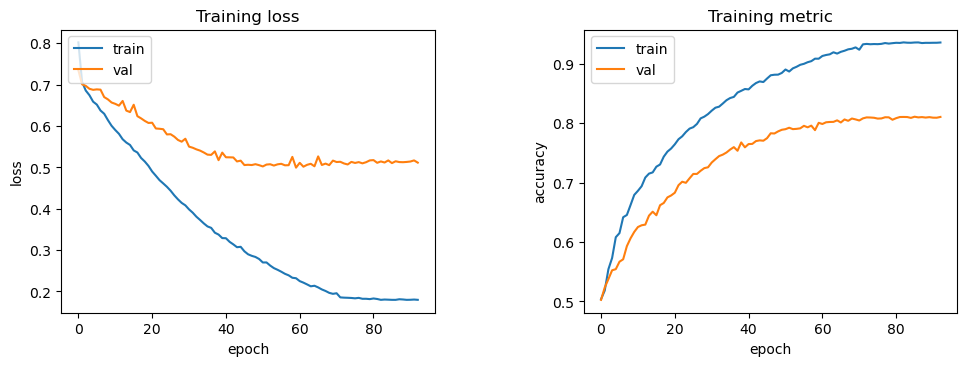

Epoch: 93 - Train Loss: 0.1796 / Validation Loss: 0.5111 / Train acc: 0.9358 / Val acc: 0.8105 / Learning Rate : 0.0000:   0%|          | 93/1000000 [03:21<601:33:20,  2.17s/it]


Starting training for model B


Epoch: 44 - Train Loss: 0.1735 / Validation Loss: 0.4394 / Train acc: 0.9392 / Val acc: 0.8307 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<601:32:47,  2.17s/it]

Training has converged after 44 epochs (lr < 1e-06)


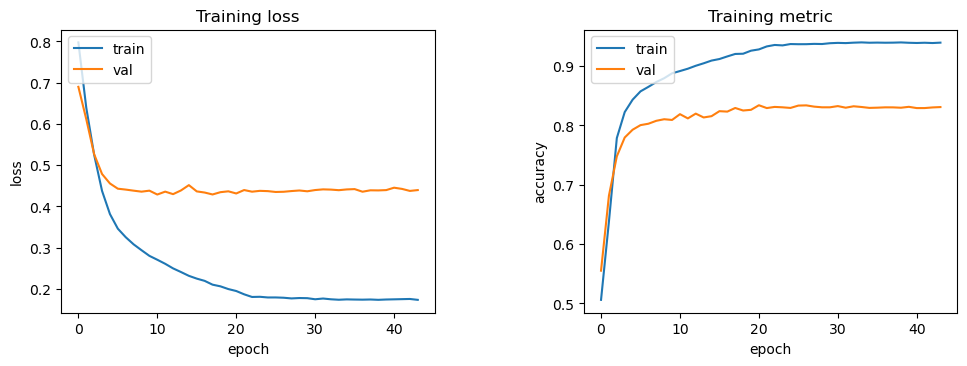

Epoch: 44 - Train Loss: 0.1735 / Validation Loss: 0.4394 / Train acc: 0.9392 / Val acc: 0.8307 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<602:17:11,  2.17s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
A loss: 0.4984353830416997 - accuracy: 0.8193418133273165 - f1: 0.8197664618492126
B loss: 0.43884223451217014 - accuracy: 0.829847204986462 - f1: 0.8302589058876038
random loss: 0.7296910136938095 - accuracy: 0.49552908299488563 - f1: 0.4958537817001343
OT_pre_uniform loss: 0.8524809877077738 - accuracy: 0.7209951536176293 - f1: 0.7182264924049377
OT_pre_random loss: 0.8583673735459646 - accuracy: 0.7192000883724428 - f1: 0.7182264924049377
OT_pre_gaussian loss: 0.8563617815574011 - accuracy: 0.7192000883724428 - f1: 0.7182264924049377
OT_pre_geometric loss: 0.8615896701812744 - accuracy: 0.7174050231272562 - f1: 0.7182264924049377
vanilla_pre loss: 1.287922590970993 - accuracy: 0.6073989592734657 - f1: 0.6058554649353027
Starting retraining for model vanilla fusion


Epoch: 110 - Train Loss: 0.1952 / Validation Loss: 0.4628 / Train acc: 0.9360 / Val acc: 0.8030 / Learning Rate : 0.0000:   0%|          | 110/1000000 [03:47<578:38:36,  2.08s/it]

Training has converged after 110 epochs (lr < 1e-06)


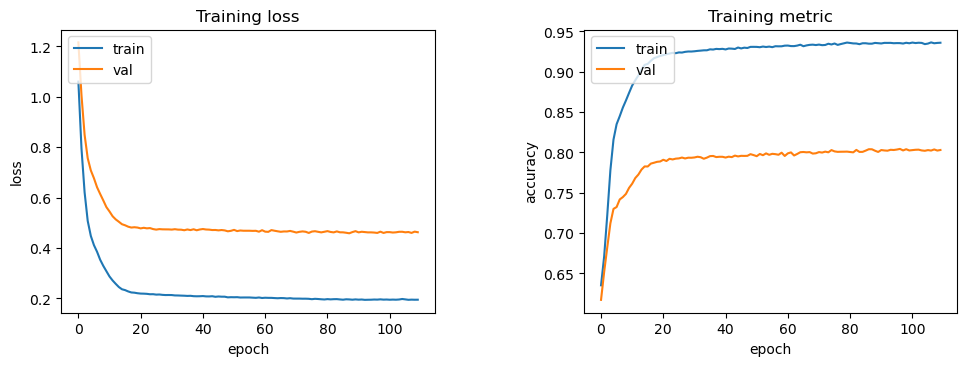

Epoch: 110 - Train Loss: 0.1952 / Validation Loss: 0.4628 / Train acc: 0.9360 / Val acc: 0.8030 / Learning Rate : 0.0000:   0%|          | 110/1000000 [03:47<574:55:34,  2.07s/it]


Starting retraining for model OT fusion - uniform


Epoch: 100 - Train Loss: 0.1944 / Validation Loss: 0.4697 / Train acc: 0.9351 / Val acc: 0.8030 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:26<571:27:32,  2.06s/it]

Training has converged after 100 epochs (lr < 1e-06)


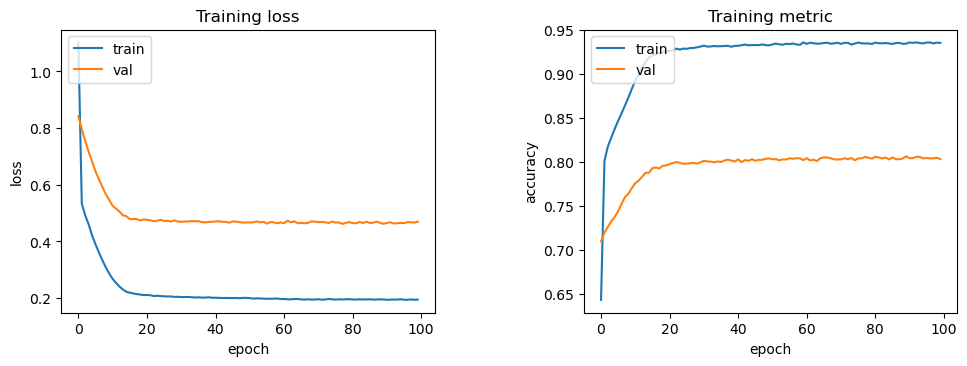

Epoch: 100 - Train Loss: 0.1944 / Validation Loss: 0.4697 / Train acc: 0.9351 / Val acc: 0.8030 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:26<573:56:18,  2.07s/it]


Starting retraining for model OT fusion - random


Epoch: 82 - Train Loss: 0.1969 / Validation Loss: 0.4671 / Train acc: 0.9342 / Val acc: 0.8032 / Learning Rate : 0.0000:   0%|          | 82/1000000 [02:49<576:07:52,  2.07s/it]

Training has converged after 82 epochs (lr < 1e-06)


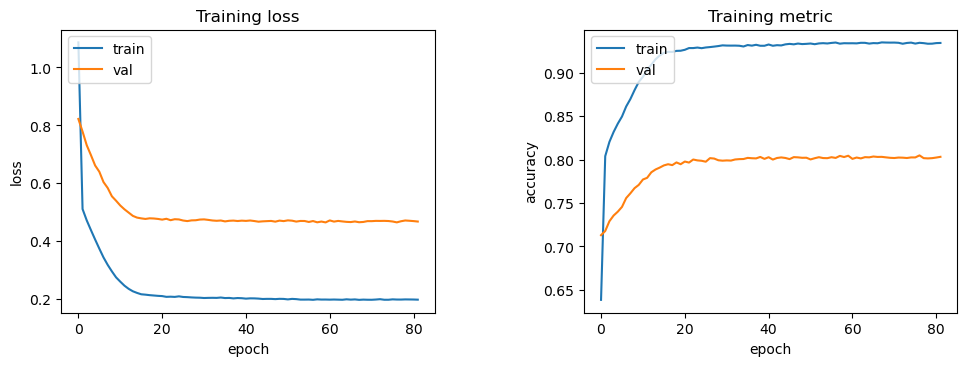

Epoch: 82 - Train Loss: 0.1969 / Validation Loss: 0.4671 / Train acc: 0.9342 / Val acc: 0.8032 / Learning Rate : 0.0000:   0%|          | 82/1000000 [02:49<574:35:31,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 88 - Train Loss: 0.1963 / Validation Loss: 0.4674 / Train acc: 0.9342 / Val acc: 0.8033 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:01<572:40:13,  2.06s/it]

Training has converged after 88 epochs (lr < 1e-06)


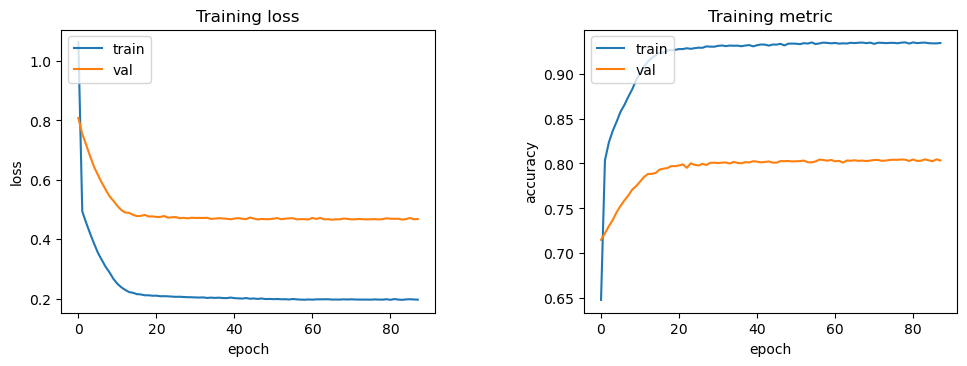

Epoch: 88 - Train Loss: 0.1963 / Validation Loss: 0.4674 / Train acc: 0.9342 / Val acc: 0.8033 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:01<574:22:05,  2.07s/it]


Starting retraining for model OT fusion - geometric


Epoch: 71 - Train Loss: 0.2031 / Validation Loss: 0.4708 / Train acc: 0.9317 / Val acc: 0.8007 / Learning Rate : 0.0000:   0%|          | 71/1000000 [02:26<573:13:22,  2.06s/it]

Training has converged after 71 epochs (lr < 1e-06)


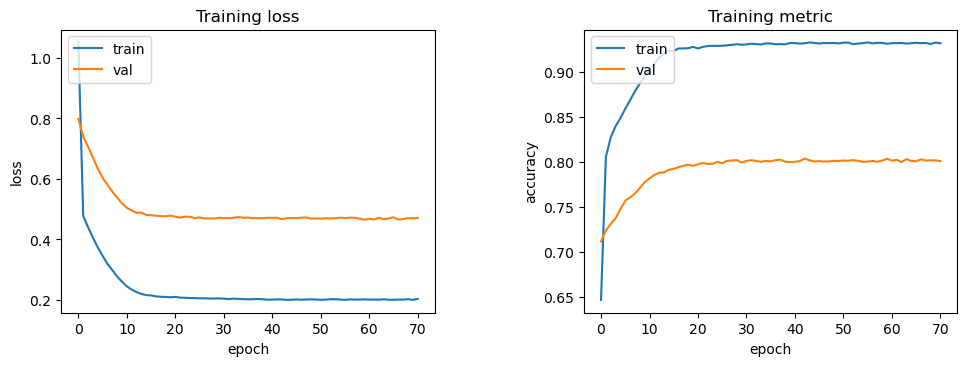

Epoch: 71 - Train Loss: 0.2031 / Validation Loss: 0.4708 / Train acc: 0.9317 / Val acc: 0.8007 / Learning Rate : 0.0000:   0%|          | 71/1000000 [02:26<574:48:27,  2.07s/it]


OT_post_uniform loss: 0.49958963692188263 - accuracy: 0.7883039306934416 - f1: 0.7877813577651978
OT_post_random loss: 0.484135905901591 - accuracy: 0.7963138584912756 - f1: 0.7972584366798401
OT_post_gaussian loss: 0.4694123640656471 - accuracy: 0.8039829883047532 - f1: 0.8025045990943909
OT_post_geometric loss: 0.472372608880202 - accuracy: 0.8001954300165464 - f1: 0.8011507987976074
vanilla_post loss: 0.5218038211266199 - accuracy: 0.775756689041817 - f1: 0.775596559047699
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22256.85it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 89 - Train Loss: 0.1840 / Validation Loss: 0.4999 / Train acc: 0.9343 / Val acc: 0.8086 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:12<604:09:03,  2.18s/it]

Training has converged after 89 epochs (lr < 1e-06)


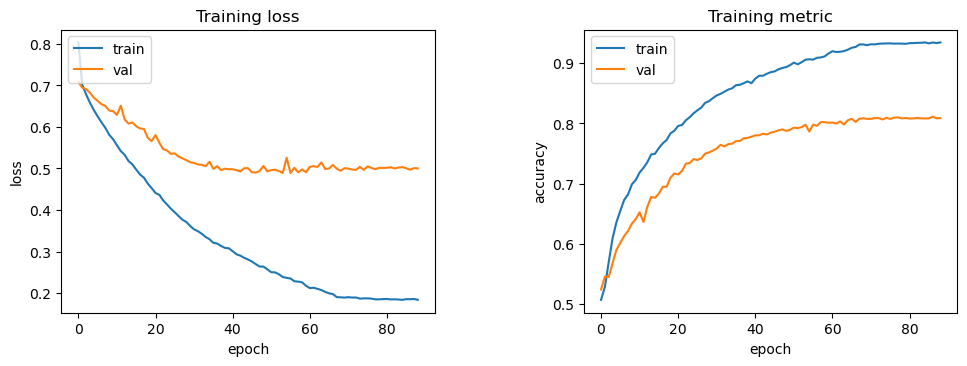

Epoch: 89 - Train Loss: 0.1840 / Validation Loss: 0.4999 / Train acc: 0.9343 / Val acc: 0.8086 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:12<601:16:02,  2.16s/it]


Starting training for model B


Epoch: 44 - Train Loss: 0.1692 / Validation Loss: 0.4067 / Train acc: 0.9394 / Val acc: 0.8392 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<602:51:11,  2.17s/it]

Training has converged after 44 epochs (lr < 1e-06)


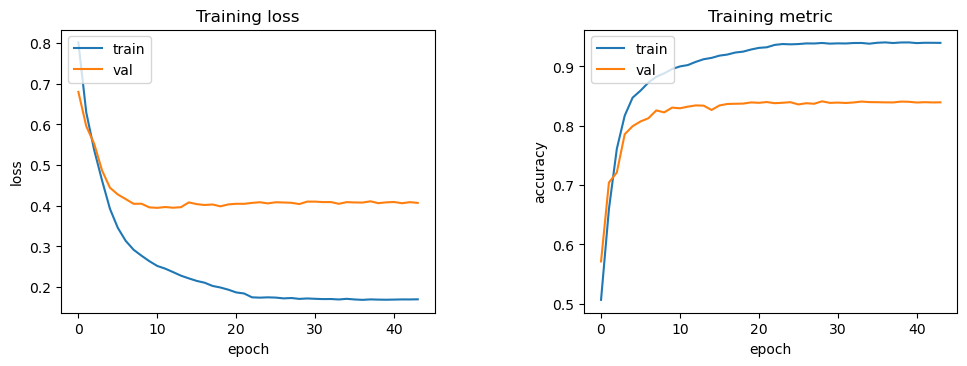

Epoch: 44 - Train Loss: 0.1692 / Validation Loss: 0.4067 / Train acc: 0.9394 / Val acc: 0.8392 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<602:03:21,  2.17s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
A loss: 0.45181245108445484 - accuracy: 0.830725053587545 - f1: 0.8305974006652832
B loss: 0.4053984507918358 - accuracy: 0.8398790049638989 - f1: 0.8393975496292114
random loss: 0.7692198803027471 - accuracy: 0.4890039767599278 - f1: 0.4899305999279022
OT_pre_uniform loss: 1.085918168226878 - accuracy: 0.6211201912229242 - f1: 0.6204095482826233
OT_pre_random loss: 1.0960263113180797 - accuracy: 0.6189108801519254 - f1: 0.6204095482826233
OT_pre_gaussian loss: 1.0894364615281422 - accuracy: 0.6209821092809867 - f1: 0.6204095482826233
OT_pre_geometric loss: 1.0918159733215969 - accuracy: 0.620429781513237 - f1: 0.6204095482826233
vanilla_pre loss: 0.9321177999178568 - accuracy: 0.6533761328595066 - f1: 0.6522254347801208
Starting retraining for model vanilla fusion


Epoch: 91 - Train Loss: 0.2078 / Validation Loss: 0.4685 / Train acc: 0.9301 / Val acc: 0.7947 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:07<580:54:20,  2.09s/it]

Training has converged after 91 epochs (lr < 1e-06)


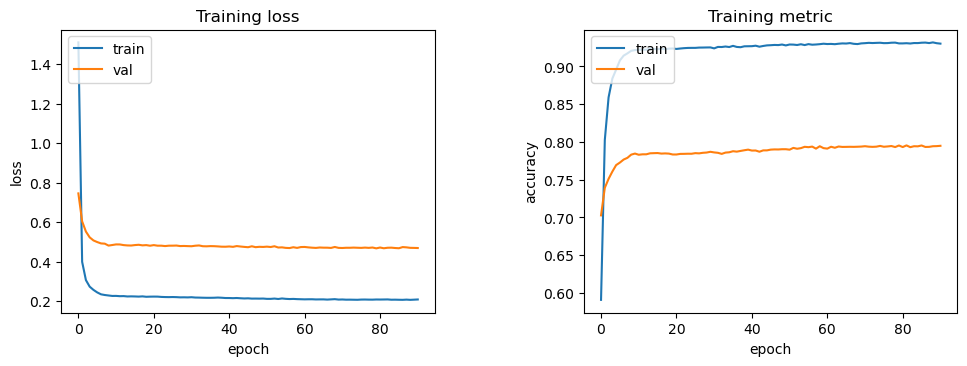

Epoch: 91 - Train Loss: 0.2078 / Validation Loss: 0.4685 / Train acc: 0.9301 / Val acc: 0.7947 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:08<574:21:28,  2.07s/it]


Starting retraining for model OT fusion - uniform


Epoch: 119 - Train Loss: 0.1801 / Validation Loss: 0.4326 / Train acc: 0.9425 / Val acc: 0.8164 / Learning Rate : 0.0000:   0%|          | 119/1000000 [04:05<572:42:05,  2.06s/it]

Training has converged after 119 epochs (lr < 1e-06)


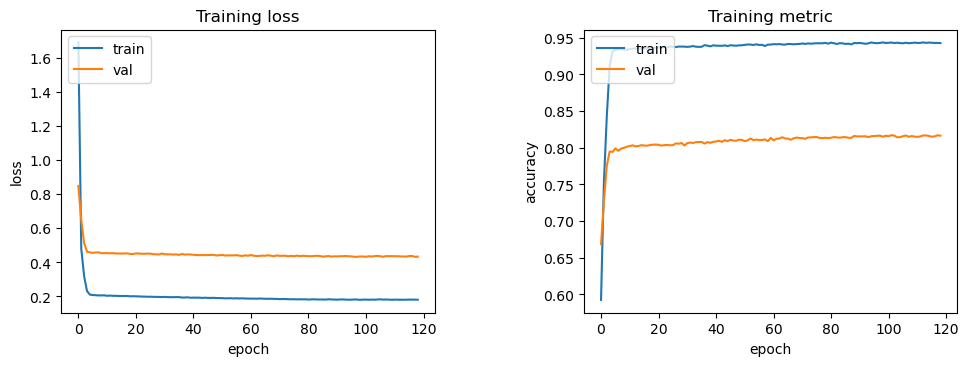

Epoch: 119 - Train Loss: 0.1801 / Validation Loss: 0.4326 / Train acc: 0.9425 / Val acc: 0.8164 / Learning Rate : 0.0000:   0%|          | 119/1000000 [04:06<574:29:47,  2.07s/it]


Starting retraining for model OT fusion - random


Epoch: 130 - Train Loss: 0.1777 / Validation Loss: 0.4335 / Train acc: 0.9432 / Val acc: 0.8164 / Learning Rate : 0.0000:   0%|          | 130/1000000 [04:28<572:14:36,  2.06s/it]

Training has converged after 130 epochs (lr < 1e-06)


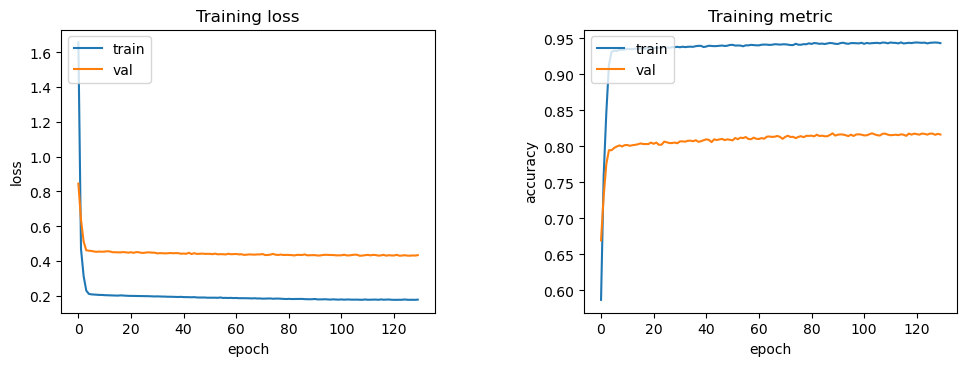

Epoch: 130 - Train Loss: 0.1777 / Validation Loss: 0.4335 / Train acc: 0.9432 / Val acc: 0.8164 / Learning Rate : 0.0000:   0%|          | 130/1000000 [04:28<574:14:05,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 125 - Train Loss: 0.1771 / Validation Loss: 0.4318 / Train acc: 0.9441 / Val acc: 0.8168 / Learning Rate : 0.0000:   0%|          | 125/1000000 [04:18<575:45:10,  2.07s/it]

Training has converged after 125 epochs (lr < 1e-06)


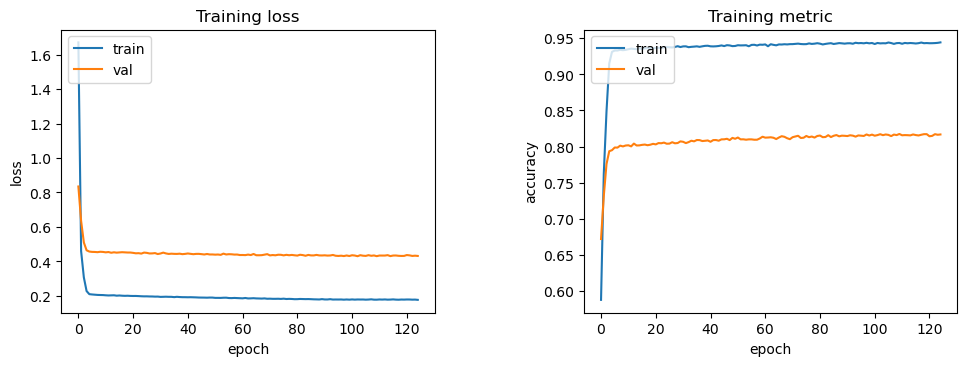

Epoch: 125 - Train Loss: 0.1771 / Validation Loss: 0.4318 / Train acc: 0.9441 / Val acc: 0.8168 / Learning Rate : 0.0000:   0%|          | 125/1000000 [04:18<574:24:57,  2.07s/it]


Starting retraining for model OT fusion - geometric


Epoch: 161 - Train Loss: 0.1744 / Validation Loss: 0.4307 / Train acc: 0.9434 / Val acc: 0.8199 / Learning Rate : 0.0000:   0%|          | 161/1000000 [05:32<571:52:43,  2.06s/it]

Training has converged after 161 epochs (lr < 1e-06)


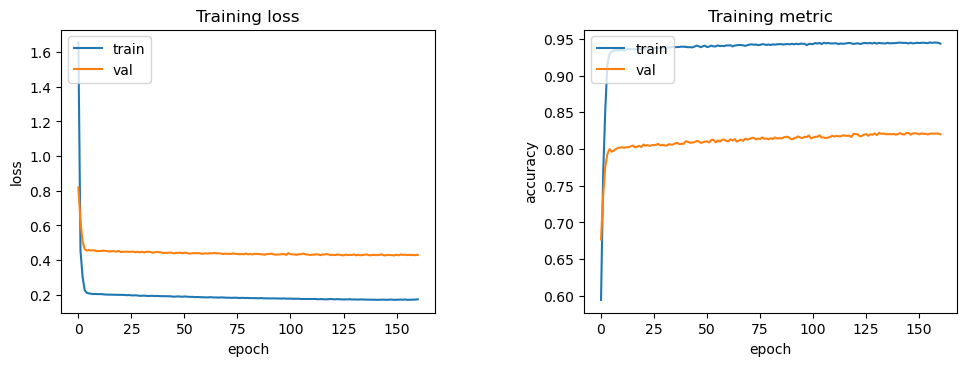

Epoch: 161 - Train Loss: 0.1744 / Validation Loss: 0.4307 / Train acc: 0.9434 / Val acc: 0.8199 / Learning Rate : 0.0000:   0%|          | 161/1000000 [05:32<574:06:44,  2.07s/it]


OT_post_uniform loss: 0.4355766053001086 - accuracy: 0.812757361236462 - f1: 0.8124894499778748
OT_post_random loss: 0.4354814638694127 - accuracy: 0.8140794223826715 - f1: 0.8158740997314453
OT_post_gaussian loss: 0.43559301644563675 - accuracy: 0.8140053869584838 - f1: 0.8153663873672485
OT_post_geometric loss: 0.4329892347256343 - accuracy: 0.820180293885379 - f1: 0.8207818865776062
vanilla_post loss: 0.4731498286128044 - accuracy: 0.7912336181934416 - f1: 0.7908275723457336
CPU times: total: 1h 44min 51s
Wall time: 1h 45min 30s


In [37]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        train_parent = lambda x: train_early_stopping(model_name=x,
                                                      train_iter=train_iterator,
                                                      valid_iter=test_iterator,
                                                      embedding=embedding,
                                                      pad_idx=pad_idx,
                                                      voc_size=voc_size,
                                                      device=device,
                                                      epochs=EPOCHS,
                                                      lr=LEARNING_RATE,
                                                      save=False)
        print('Starting training for model A')
        modelA = train_parent('A')
        print('Starting training for model B')
        modelB = train_parent('B')

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        # 2.1) uniform
        model_fusion_uniform = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=0.5,
                                         pmd_name=probability_mass_distribution_names[0])
        # 2.2) random
        model_fusion_random = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=0.5,
                                         pmd_name=probability_mass_distribution_names[1])
        # 2.3) gaussian
        model_fusion_gaussian = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=0.5,
                                         pmd_name=probability_mass_distribution_names[2])
        # 2.4) geometric
        model_fusion_geometric = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=0.5,
                                         pmd_name=probability_mass_distribution_names[3])

        # evaluate
        # ensure all models on same device
        model_to_cpu = lambda x: x.to(device)
        modelA = model_to_cpu(modelA)
        modelB = model_to_cpu(modelB)
        model_random = new_model(embedding, pad_idx, voc_size, device)
        model_fusion_uniform = model_to_cpu(model_fusion_uniform)
        model_fusion_random = model_to_cpu(model_fusion_random)
        model_fusion_gaussian = model_to_cpu(model_fusion_gaussian)
        model_fusion_geometric = model_to_cpu(model_fusion_geometric)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('A', 'B', 'random', 'OT_pre_uniform', 'OT_pre_random', 'OT_pre_gaussian', 'OT_pre_geometric', 'vanilla_pre'),
                               (modelA, modelB, model_random, model_fusion_uniform, model_fusion_random, model_fusion_gaussian,
                                model_fusion_geometric, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        retrain = lambda x: train(model=x,
                                  iterator=train_iterator,
                                  valid_iter=test_iterator,
                                  optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                                  criterion=nn.CrossEntropyLoss(),
                                  epoch=EPOCHS,
                                  clip=1,
                                  device=device)
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        retrain(model_fusion_vanilla)

        # 2) optimal transport
        # train with early stopping
        print('Starting retraining for model OT fusion - uniform')
        retrain(model_fusion_uniform)
        print('Starting retraining for model OT fusion - random')
        retrain(model_fusion_random)
        print('Starting retraining for model OT fusion - gaussian')
        retrain(model_fusion_gaussian)
        print('Starting retraining for model OT fusion - geometric')
        retrain(model_fusion_geometric)

        # evaluate
        # ensure all models on same device
        model_fusion_uniform = model_to_cpu(model_fusion_uniform)
        model_fusion_random = model_to_cpu(model_fusion_random)
        model_fusion_gaussian = model_to_cpu(model_fusion_gaussian)
        model_fusion_geometric = model_to_cpu(model_fusion_geometric)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('OT_post_uniform', 'OT_post_random', 'OT_post_gaussian', 'OT_post_geometric', 'vanilla_post'),
                               (model_fusion_uniform, model_fusion_random, model_fusion_gaussian,
                                model_fusion_geometric, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [38]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport (uniform)', 'Optimal transport (uniform - retraining)',
                     'Optimal transport (random)', 'Optimal transport (random - retraining)', 'Optimal transport (gaussian)', 'Optimal transport (gaussian - retraining)', 'Optimal transport (geometric)', 'Optimal transport (geometric - retraining)', 'Untrained model (baseline)']

In [39]:
latex = scores_to_latex(scores, model_names_latex)

                                                  loss  \
A                  [0.439, 0.469, 0.472, 0.498, 0.452]   
B                  [0.402, 0.434, 0.398, 0.439, 0.405]   
vanilla_pre        [1.954, 0.987, 0.798, 1.288, 0.932]   
vanilla_post       [0.428, 0.476, 0.457, 0.522, 0.473]   
OT_pre_uniform     [0.488, 3.262, 0.506, 0.852, 1.086]   
OT_post_uniform       [0.429, 0.45, 0.435, 0.5, 0.436]   
OT_pre_random      [0.491, 3.264, 0.507, 0.858, 1.096]   
OT_post_random     [0.422, 0.449, 0.427, 0.484, 0.435]   
OT_pre_gaussian    [0.486, 3.279, 0.504, 0.856, 1.089]   
OT_post_gaussian   [0.424, 0.451, 0.433, 0.469, 0.436]   
OT_pre_geometric   [0.484, 3.251, 0.506, 0.862, 1.092]   
OT_post_geometric  [0.421, 0.448, 0.428, 0.472, 0.433]   
random              [0.721, 0.765, 0.745, 0.73, 0.769]   

                                              accuracy  \
A                  [0.841, 0.824, 0.828, 0.819, 0.831]   
B                    [0.842, 0.831, 0.843, 0.83, 0.84]   
vanilla_pre  

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\DL Project\CV\utils.py:1052: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [40]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_seeds_mass_distributions.txt','w') as dat:
    dat.write(str(latex))

Notes: weighted fusion collapses to 0, 1 -> use average